## SOM
The basic algorithm is fairly simple. For each training example:
1. Calculate the similarity between the input pattern and the weights arriving
at each output node.
2. Find the most similar node; often referred to as the
winner .
3. Select a set of output nodes which are located close to the winner
output grid .
This is called the
neighbourhood .
in the
4. Update the weights of all nodes in the neighbourhood such that their

In [1]:
import os
%matplotlib inline
import numpy as np
import pandas as pd
from math import floor
from matplotlib import colors
from matplotlib import pyplot as plt
datasets_folder = "../datasets"

In [2]:
class SelfOrganizingMap:
    def __init__(self, X, nw):
        self.X = X     # n x d; # access sample: self.X[:, i]
        self.nw = nw   # n units
        self.Ws = np.random.rand(self.nw, self.X.shape[1]) # n units x d
    
    def winning_node(self, x):
        # compute distances and return minimum index
        return np.argmin(np.linalg.norm(x - self.Ws, axis=1)) # access index: self.Ws[d, :]

    def train1D(self, neigh_seq, n_epochs=20, eta=0.2, reinit=False):
        """
        Trains the model considering nodes as a round 1D vector 
        """
        if reinit: # Reinitialize model:
            self.Ws = np.random.rand(self.nw, self.X.shape[1])
        for i in range(n_epochs):
            # Neighborhood sequence, hyper-parameter
            neighborhood = neigh_seq[i] if i < len(neigh_seq) else 0 
            for x in self.X:
                sub = x - self.Ws # Gives us the updates "for free"
                win_id = np.argmin(np.linalg.norm(sub, axis=1)) # winning node
                # Build the sequence of units to be updated
                idx_updates = [i % self.nw for i in range(
                    win_id - neighborhood,
                    win_id + neighborhood +1
                )]
                # Perform updates
                self.Ws[idx_updates, :] += eta * sub[idx_updates, :]
    
    def train2D(self, neigh_seq, ncol, n_epochs=20, eta=0.2, reinit=False):
        """
        Trains the model considering nodes as a 2D plane
        """
        if reinit:
            self.Ws = np.random.rand(self.nw, self.X.shape[1])
        # Same a 1D but considers output nodes as a 2D grid for neighborhood updates
        nlin = self.nw // ncol
        for i in range(n_epochs):
            neighborhood = neigh_seq[i] if i < len(neigh_seq) else 0
            for x in self.X:
                sub = x - self.Ws
                win_id = np.argmin(np.linalg.norm(sub, axis=1))
                # Compute points within Manhattan distance
                lin = win_id // ncol
                col = win_id % ncol
                idx_updates = [ 
                    i for i in range(ncol * nlin)
                    if col-1 <= i % ncol <= col+1 
                    and lin-1 <= i // ncol <= lin+1
                ]
                self.Ws[idx_updates, :] += eta * sub[idx_updates, :]
    
    def animals_topological(self, names, plot=True):
        """
        4.1
        Compares input space to 1D output space
        """
        res = [(n, self.winning_node(x)) for x, n in zip(self.X, names)]
        res.sort(key=lambda tup: tup[1])
        if plot: # Put them on a circle to illustrate roundness
            xy = lambda r, phi: (r * np.cos(phi), r*np.sin(phi))
            f = plt.figure(figsize=(15,12), dpi=100, facecolor='w', edgecolor='k', frameon=False)
            phis=np.arange(0, 2*np.pi, 2*np.pi/len(res))
            for (name, node), x, y in zip(res, *xy(1., phis)):
                plt.annotate(str(node) + " - " + str(name), xy=(x, y),
                             textcoords='data', fontsize="large", rotation=10)
                plt.plot(x, y, ".")
            plt.title("SOM Round 1D result, plotted as a circle")
            plt.show()
        return res
    
    def TSP_graphical(self, labels=("cities", "tour"), comment=""):
        """
        4.2
        Plot model vectors into the input space
        """
        f = plt.figure(figsize=(3.3,3), dpi=100, facecolor='w', edgecolor='k')
        i = 0
        for x in self.X:
            if i == 0: # For legend
                i = 1
                plt.plot(x[0], x[1], 'ro', label=labels[0])
            plt.plot(x[0], x[1], 'ro')
        Xs = [x[0] for x in self.Ws]
        Ys = [x[1] for x in self.Ws]
        # To close loop
        Xs.append(Xs[0])
        Ys.append(Ys[0])
        plt.plot(Xs, Ys, 'b', label=labels[1])
        plt.plot(Xs, Ys, 'bx')
        plt.xlabel("x coord")
        plt.ylabel("y coord")
        plt.legend()
        plt.title("TSP Using SOM"+ comment)
        plt.show()
    
    @staticmethod
    def MP_plot(res, metric, c_labels, title):
        f = plt.figure(figsize=(4,4), dpi=100, facecolor='w', edgecolor='k')
        N = 10 # Size of grid
        data = np.ones((N, N)) * np.nan # empty data set
        for _, row in res.iterrows(): # Fill
            x = int(row["wn"] // N)
            y = int(row["wn"] % N)
            data[x,y] = row[metric]+1 if data[x,y] != row[metric]+1 else 0

        ax = f.subplots(1, 1)
        if metric == "sex":
            cs = ['g', 'r', 'b']
        elif metric == "party":
            cs = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']
        else:
            cs = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'] 
        my_cmap = colors.ListedColormap(cs)
        my_cmap.set_bad(color='w', alpha=0)
        # Grid
        for x in range(N + 1):
            ax.axhline(x, lw=2, color='k', zorder=5)
            ax.axvline(x, lw=2, color='k', zorder=5)
        # Boxes
        cax = ax.imshow(data, interpolation='none', cmap=my_cmap, extent=[0, N, 0, N], zorder=0)
        # Colorbar legend
        cbar = f.colorbar(cax, ticks=list(range(len(c_labels))), orientation='horizontal')
        cbar.ax.set_xticklabels(c_labels)  # horizontal colorbar
        # turn off the axis labels
        ax.axis('off')
        plt.title(title)
        plt.show()

### 4.1 Animal Species
#### Load Data

In [3]:
namesa = pd.read_csv(os.path.join(datasets_folder, "animalnames.txt"), header=None)
namesa = namesa[0].str.strip() # Remove trailing characters
namesa = namesa.str.strip("'")

attra = pd.read_csv(os.path.join(datasets_folder, "animalattributes.txt"), header=None)[0]
# Names and attributes gives us dimensions
na = len(namesa)
da = len(attra)
# Open files, get 1st line, remove line feed, split over ',', reshape into matrix
with open(os.path.join(datasets_folder, "animals.dat"), 'r') as f:
    Da = np.array(next(f)[:-1].split(",")).reshape(na, da).astype("int32")

#### Train and results

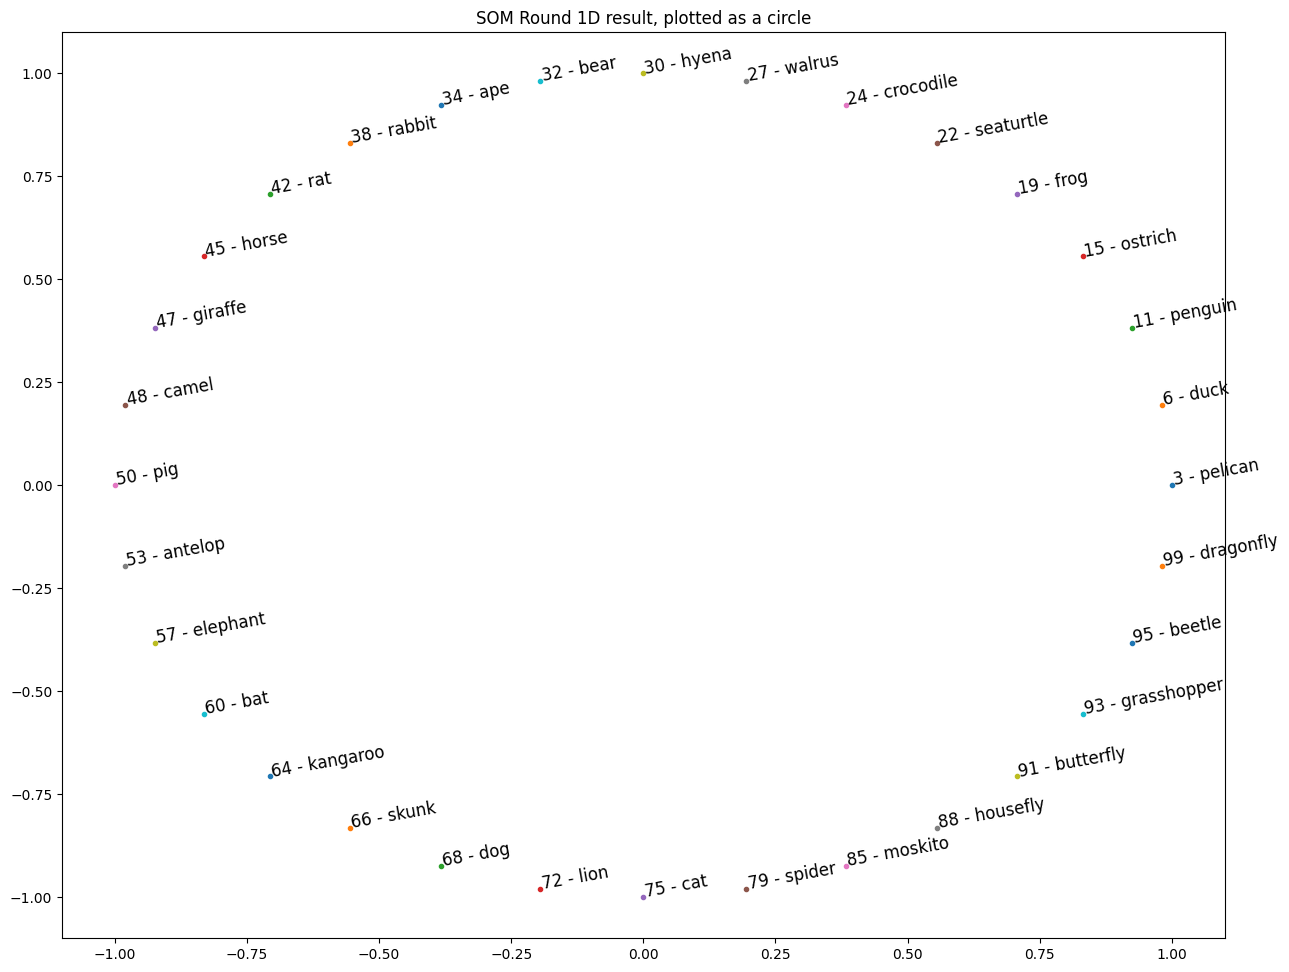

In [4]:
SOMa = SelfOrganizingMap(Da, 100)
animals_seq = [floor((50) / (max((2*i), 1))) for i in range(8)] + 3 * [2] + 3 * [1] + 6 * [0]
SOMa.train1D(animals_seq, n_epochs=20)
ls = SOMa.animals_topological(namesa, plot=True)

In [5]:
for r in ls:
    print(r, end="")

('pelican', 3)('duck', 6)('penguin', 11)('ostrich', 15)('frog', 19)('seaturtle', 22)('crocodile', 24)('walrus', 27)('hyena', 30)('bear', 32)('ape', 34)('rabbit', 38)('rat', 42)('horse', 45)('giraffe', 47)('camel', 48)('pig', 50)('antelop', 53)('elephant', 57)('bat', 60)('kangaroo', 64)('skunk', 66)('dog', 68)('lion', 72)('cat', 75)('spider', 79)('moskito', 85)('housefly', 88)('butterfly', 91)('grasshopper', 93)('beetle', 95)('dragonfly', 99)

### 4.2 Cyclic tour
#### Load Data

In [6]:
with open(os.path.join(datasets_folder, "cities.dat"), 'r') as f:
    cities = np.array([l[:-2].split(',') for l in f.readlines()[4:]]).astype("float")

#### Train and results 

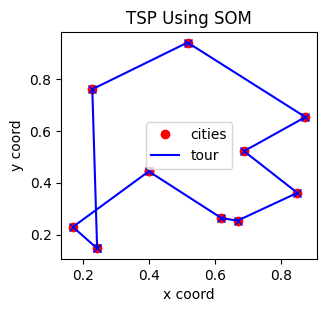

In [7]:
SOMc = SelfOrganizingMap(cities, 10)
cities_seq = 4 * [2] + 6 * [1]
SOMc.train1D(cities_seq, n_epochs=20, eta=0.65)
SOMc.TSP_graphical()

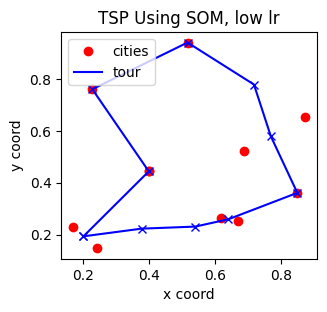

In [8]:
SOMc = SelfOrganizingMap(cities, 10)
cities_seq = 12 * [2] + 18 * [1]
SOMc.train1D(cities_seq, n_epochs=60, eta=0.225) # 0.85
SOMc.TSP_graphical(comment=", low lr")

### 4.3 Data Clustering: Votes of MPs
#### Load Data

In [9]:
Dmp = pd.DataFrame()
Dmp['name'] = pd.read_csv(os.path.join(datasets_folder, "mpnames.txt"), encoding="iso8859_10", header=None)[0]

with open(os.path.join(datasets_folder, "mpdistrict.dat"), 'r') as f:
    Dmp['district'] = pd.Series(f.readlines())
    Dmp['district'] = Dmp['district'].str.strip()

with open(os.path.join(datasets_folder, "mpparty.dat"), 'r') as f:
    Dmp['party'] = pd.Series(f.readlines()[3:])
    Dmp['party'] = Dmp['party'].str.strip()

with open(os.path.join(datasets_folder, "mpsex.dat"), 'r') as f:
    Dmp['sex'] = pd.Series(f.readlines()[2:])
    Dmp['sex'] = Dmp['sex'].str.strip()
    
with open(os.path.join(datasets_folder, "votes.dat"), 'r') as f:
    votes = np.array(next(f)[:-1].split(","))
    votes = votes.reshape(Dmp.shape[0], int(len(votes)/Dmp.shape[0])).astype("float")
    Dmp = pd.concat([Dmp, pd.DataFrame(votes)], axis=1)
    
Dmp.loc[:, Dmp.columns != 'name'] = Dmp.loc[:, Dmp.columns != 'name'].astype("float")

#### Train and results 
##### Sex

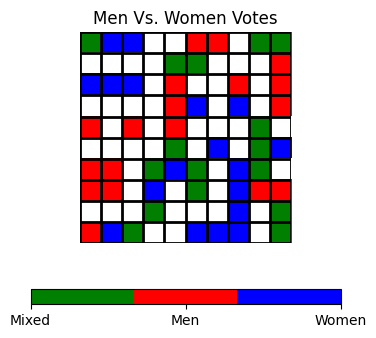

In [10]:
# for i in range(20):
SOMmp = SelfOrganizingMap(Dmp.drop(["name", "district", "party"], axis=1).values, 100)
SOMmp.train2D(10 * [2] + 25 * [1], ncol=10, n_epochs=60, eta=0.33)
res = pd.DataFrame(Dmp["sex"])
# Compute winning nodes for plotting
res["wn"] = np.array([SOMmp.winning_node(row.values.astype("float")) for _, row in Dmp.drop(["name", "district", "party"], axis=1).iterrows()])
SOMmp.MP_plot(res, "sex", ["Mixed", "Men", "Women"], "Men Vs. Women Votes")

##### Party
lots of runs were necessary to find a satisfying clustering

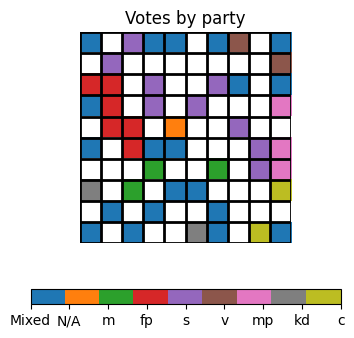

In [11]:
SOMmp = SelfOrganizingMap(Dmp.drop(["name", "district", "sex"], axis=1).values, 100)
SOMmp.train2D(30 * [2] + 10 * [1], ncol=10, n_epochs=60, eta=0.42)
res = pd.DataFrame(Dmp["party"])
res["wn"] = np.array([SOMmp.winning_node(row.values.astype("float")) for _, row in Dmp.drop(["name", "district", "sex"], axis=1).iterrows()])
SOMmp.MP_plot(res, "party", ['Mixed', 'N/A', 'm', 'fp', 's', 'v', 'mp', 'kd', 'c'], "Votes by party")

##### District

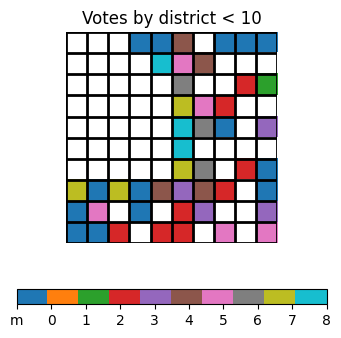

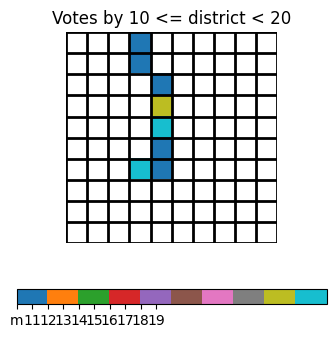

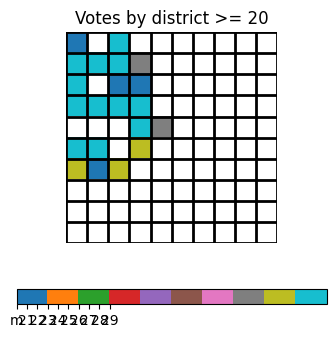

In [12]:
SOMmp = SelfOrganizingMap(Dmp.drop(["name", "sex", "party"], axis=1).values, 100)
SOMmp.train2D(10 * [2] + 25 * [1], ncol=10, n_epochs=60, eta=0.33)
res = pd.DataFrame(Dmp["district"])
res["wn"] = np.array([SOMmp.winning_node(row.values.astype("float")) for _, row in Dmp.drop(["name", "sex", "party"], axis=1).iterrows()])
SOMmp.MP_plot(res[res["district"] < 10], "district", ["m"] + list(range(10)), "Votes by district < 10")
SOMmp.MP_plot(res.query('district >= 10 & district < 20'), "district", ["m"] + list(range(11,20)), "Votes by 10 <= district < 20")
SOMmp.MP_plot(res[res["district"] >= 20], "district", ["m"] + list(range(21,30)), "Votes by district >= 20")